# Informer Demo

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
drive

<module 'google.colab.drive' from '/usr/local/lib/python3.10/dist-packages/google/colab/drive.py'>

## Download code and dataset

In [3]:
# !git clone https://github.com/zhouhaoyi/Informer2020.git
# !git clone https://github.com/zhouhaoyi/ETDataset.git
# !ls

In [4]:
import sys
print(sys.path)
sys.path += ['/content/drive/MyDrive/informer']
sys.path += ['/content/drive/MyDrive/informer/Informer2020']
sys.path += ['/content/drive/MyDrive/informer/ETDataset']
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [5]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [6]:
try:
  from utils.tools import dotdict
  from exp.exp_informer import Exp_Informer
  import torch
except:
  from drive.informer.Informer2020.utils.tools import dotdict
  from drive.informer.Informer2020.exp.exp_informer import Exp_Informer
  import torch

In [7]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'heartbeat' # data
args.root_path = '/content/drive/MyDrive/informer/' # root path of data file
args.data_path = 'trainRR.csv' # data file
args.features = 'S' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariatefreq
args.target = 'data' # target feature in S or MS task
args.freq = 's' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = '/content/drive/MyDrive/informer/informer_checkpoints' # location of model checkpoints

args.seq_len = 80 # input sequence length of Informer encoder
args.label_len = 40 # start token length of Informer decoder
args.pred_len = 25 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 1024 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.00 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.inverse=True

args.batch_size = 36
args.learning_rate = 0.00001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 25
args.patience = 5
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [8]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]
# Set augments by using data name
data_parser = {
    'heartbeat':{'data':'trainRR.csv','T':'data','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]
args.detail_freq = args.freq
args.freq = args.freq[-1:]
print('Args in experiment:')
print(args)
Exp = Exp_Informer

Args in experiment:
{'model': 'informer', 'data': 'heartbeat', 'root_path': '/content/drive/MyDrive/informer/', 'data_path': 'trainRR.csv', 'features': 'S', 'target': 'data', 'freq': 's', 'checkpoints': '/content/drive/MyDrive/informer/informer_checkpoints', 'seq_len': 80, 'label_len': 40, 'pred_len': 25, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'factor': 5, 'd_model': 1024, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.0, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'inverse': True, 'batch_size': 36, 'learning_rate': 1e-05, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 25, 'patience': 5, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 's'}


In [9]:
args.learning_rate = 0.00001
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features,
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    # break
    exp = Exp(args)

    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)

    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_heartbeat_ftS_sl80_ll40_pl25_dm1024_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 6896
val 976
test 1976
	iters: 100, epoch: 1 | loss: 0.0222416
	speed: 0.2143s/iter; left time: 1001.8943s
Epoch: 1 cost time: 39.348345041275024
Epoch: 1, Steps: 191 | Train Loss: 0.0164863 Vali Loss: 0.0078550 Test Loss: 0.0080184
Validation loss decreased (inf --> 0.007855).  Saving model ...
Updating learning rate to 1e-05
	iters: 100, epoch: 2 | loss: 0.0090074
	speed: 0.4309s/iter; left time: 1932.6437s
Epoch: 2 cost time: 36.70039916038513
Epoch: 2, Steps: 191 | Train Loss: 0.0067639 Vali Loss: 0.0051748 Test Loss: 0.0049032
Validation loss decreased (0.007855 --> 0.005175).  Saving model ...
Updating learning rate to 5e-06
	iters: 100, epoch: 3 | loss: 0.0053519
	speed: 0.4254s/iter; left time: 1826.5697s
Epoch: 3 cost time: 36.79562067985535
Epoch: 3, Steps: 191 | Train Loss: 0.0045160 Vali Loss: 0.004420

## Prediction

In [10]:
## If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`
import os

# set saved model path
#setting = 'informer_heartbeat_ftS_sl24_ll12_pl1_dm256_nh24_el2_dl1_df2048_atprob_fc24_ebtimeF_dtFalse_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')
# args.pred_len = 2000
args.detail_freq = args.freq
args.freq = args.freq[-1:]
exp = Exp(args)
preds,trues = exp.predict(setting, True)

Use GPU: cuda:0
testRR.csv
pred 1897


<Figure size 640x480 with 0 Axes>

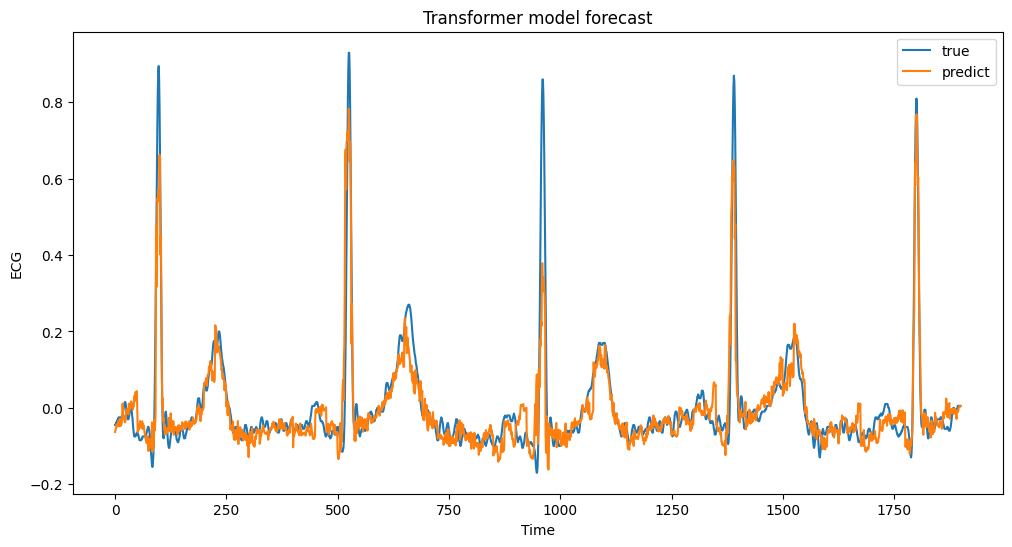

R2: 0.798552
MAPE: 1002007625728.000000
MAE: 0.035392 
RMSE: 0.064094
mse: 0.004108


In [11]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np
# setting = 'informer_heartbeat_ftS_sl96_ll48_pl1_dm512_nh12_el2_dl1_df2048_atprob_fc8_ebtimeF_dtTrue_mxTrue_exp_0'
# prediction = np.load('./results/'+setting+'/real_prediction.npy')
# true = np.load('./results/'+setting+'/true.npy')
#prediction.shape

import matplotlib.pyplot as plt
import pandas as pd
plt.figure()
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(ax=ax)
ax.plot(trues,label="true")
ax.plot(preds,label="predict")
ax.set_title("Transformer model forecast")
ax.set_ylabel("ECG")
ax.set_xlabel("Time")
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
mse = mean_squared_error(trues, preds)
mae = mean_absolute_error(trues, preds)
r2 = r2_score(trues, preds)
mape = mean_absolute_percentage_error(trues, preds)
print(f"R2: {r2:.6f}")
print(f"MAPE: {mape:.6f}")
print(f"MAE: {mae:.6f} ")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"mse: {mse:.6f}")
